<a href="https://colab.research.google.com/github/tjp1992/ML-Jupyter/blob/main/Projects/01_Stock_Analysis/Stock_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Analysis

**Following Project is intended to find the most optimal model for stock prediction**

The sole purpose for majority that invests in stock is to make profit, but not everyone gets to make profit from their investment due to the fact that not everyone is a skilled stock analyst. The goal of this project is not to make a complicated model that will predict the closing price of certain stock, but to make a classification model to predict whether the stock will increase or decrease the next day. 

Thus, we want to maximize our `True Positives` - days when algorithm predicts that the price will go up, and it actually goes up. Therefore, we'll be using precision as our error metric for the algorithm, which is `True Positives / (False Positives + True Positives)`, basically percentage of `True Positives` out of all our predictions. This will ensure minimization of loss with `False Positives`(Days when the stock has been purchased, but the price actually goes down).

This means that we will have to accept a lot of `False Negatives` - days when we predict that the price will go down, but it actually goes up. 

### Method

Before heading straight into machine learning, as it is with any other machine learning models we'll make in the future acquiring data and cleaning up the data is mandatory. The following steps will be taken:

- Download historical stock prices from Yahoo Finance
- Explore the Data
- Setup the dataset to predict future prices using historical prices
- Test a machine learning model
- Setup a backtesting engine
- Improve the accuracy of the model

At the end, potential future directions will documented to improve the technique.

### Downloading the Data

First, we'll download the data from Yahoo Finance. We'll save the data after we download it to prevent our IP from being blocked.

A Single stock(Microsoft) will be used for our model.

In [ ]:
# Import Finance API and get historical stock data

import yfinance as yf
import os
import json
import pandas as pd

DATA_PATH = 'msft_data.json'

if os.path.exists(DATA_PATH):
    # Read from file if we already downloaded the data
    with open(DATA_PATH) as f:
        msft_hist = pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period='max')
    
    # Save file to json in case we need to use it later. This prevents downloading the data from 
    # Yahoo Finance every time we restart the kernel
    msft_hist.to_json(DATA_PATH)
    

In [ ]:
msft_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13,0.055898,0.064119,0.055898,0.061378,1031788800,0.0,0.0
1986-03-14,0.061378,0.064667,0.061378,0.063570,308160000,0.0,0.0
1986-03-17,0.063570,0.065215,0.063570,0.064667,133171200,0.0,0.0
1986-03-18,0.064667,0.065215,0.062474,0.063022,67766400,0.0,0.0
1986-03-19,0.063022,0.063570,0.061378,0.061926,47894400,0.0,0.0


As seen above, one row of the data represents each day that Microsoft stock was traded.
The columns are as following:

- Open   - The price the stock opened at
- High   - Highest price during the day
- Low    - Lowest Price During the day
- Close  - the closing price on the trading day
- Volume - How many Shares were traded

Stock doesn't trade everyday (there is no trading on weekends and holidays), so some dates are bound to be missing.

Next, we'll plot the data so we can see how the stock price has changed over time, This gives us another overview of the structure of the data.

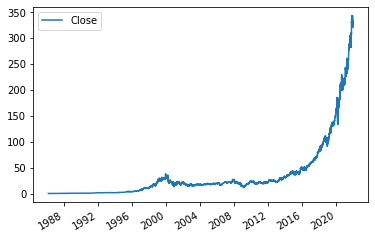

In [ ]:
# Visualize microsoft stock prices
msft_hist.plot.line(y='Close', use_index=True)

### Preparing the Data

Now that the data has been prepared, we can start making predictions for the price.

First, we'll identify a target that we're trying to predict. Our target will be if the price will go up or down tomorrow. If the price went up, the target will be `1` and if it went down, the target will be `0`.

Next, we'll shift the data from previous days 'forward' one day, so we can use it to predict the target price. This ensure that we don't accidentally use data from the same day to make predictions.

Then, we'll combine both so we have our training data.

In [ ]:
# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [ ]:
data.head(5)

,Actual_Close,Target
1986-03-13,0.061378,NaN
1986-03-14,0.063570,1.0
1986-03-17,0.064667,1.0
1986-03-18,0.063022,0.0
1986-03-19,0.061926,0.0


In [ ]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from t
# today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

In [ ]:
msft_prev.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14,0.055898,0.064119,0.055898,0.061378,1.031789e+09,0.0,0.0
1986-03-17,0.061378,0.064667,0.061378,0.063570,3.081600e+08,0.0,0.0
1986-03-18,0.063570,0.065215,0.063570,0.064667,1.331712e+08,0.0,0.0
1986-03-19,0.064667,0.065215,0.062474,0.063022,6.776640e+07,0.0,0.0


In [ ]:
msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13,0.055898,0.064119,0.055898,0.061378,1031788800,0.0,0.0
1986-03-14,0.061378,0.064667,0.061378,0.063570,308160000,0.0,0.0
1986-03-17,0.063570,0.065215,0.063570,0.064667,133171200,0.0,0.0
1986-03-18,0.064667,0.065215,0.062474,0.063022,67766400,0.0,0.0
1986-03-19,0.063022,0.063570,0.061378,0.061926,47894400,0.0,0.0


In [ ]:
# Create our training data
predictors = ['Close','Volume','Open','High','Low']
data = data.join(msft_prev[predictors]).iloc[1:]

In [ ]:
data.head(5)

### Creating a machine learning model





In [1]:
import requests
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# urls = 'https://iex.lewagon.com/stable/stock/aapl/chart/3m'
# urls = 'https://iex.lewagon.com/stable/stock//chart/3m'
# urls = 'https://iex.lewagon.com/ref-data/exchanges'

# Calls the URL to get the stock code (ticker)
def get_data(ticker):
    urls = 'https://iex.lewagon.com/stable/search/{}'
    api_data = requests.get(urls.format(ticker)).json()

    symbol = ""
    for stock in api_data:
        if 'KR' == stock['region']:
            symbol = stock['symbol']

    url = 'https://iex.lewagon.com/stable/stock/{}/chart/1y'
    result = requests.get(url.format(symbol)).json()
    result
    df = pd.DataFrame(result)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    return df

In [12]:
api_data = get_data()

SyntaxError: ignored

In [14]:
df = api_data

In [ ]:
import requests
from bs4 import BeautifulSoup

response = requests.get("https://global.krx.co.kr/contents/GLB/03/0308/0308010000/GLB0308010000.jsp", headers={"Accept-Language":"en-US"})
soup = BeautifulSoup(response.content, "html.parser")

print(soup)

In [26]:
stock_info = []

table = soup.find('tbody', class_='CI-GRID-BODY-TABLE-TBODY')

print(table)

# for code in table.find_all(
#     "tr", 
#     # class_="", 
#     # attrs=''
#     ):
#     columns = code.find_all('td')
#     # title = movie.find("h3").find("a").string
#     # duration = int(movie.find("span", class_="runtime").string.strip(' min'))
#     # movies.append({'title': title, 'duration': duration})

# print(stock_info)

None


In [4]:
symbol = ""



for li in api_data:
  if 'KR' == li['region']:
    symbol = li['symbol']

url = 'https://iex.lewagon.com/stable/stock/{}/chart/1y'
result = requests.get(url.format(symbol)).json()
result
df = pd.DataFrame(result)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = get_data(159580)

JSONDecodeError: ignored

In [15]:
go.Figure(data = [
                  go.Candlestick(
                      x=df.index,
                      open = df['uOpen'],
                      high = df['uHigh'],
                      low = df['uLow'],
                      close = df['uClose'],
                                 )
])